# Random Forest Classifier

By Steven Sison on December 16, 2023

## Description

This document will be used for the preliminary training and evaluation of the random forest classifier. The document includes the necessary processes taken to train the model with the default hyperparameters. This also evaluates the performance of the classifier in terms of accuracy, precision, recall, F1-score, training time, and detection time. Furthermore, this document will only use lexical features and will observe the effect of increasing the number of features used in the model. As this is only for preliminary work, no optimizations, except a simple train-test validation, will be carried out.

### Preliminaries

In [9]:
import pandas as pd                     # For data transformation
import numpy as numpy                   # For scientific calculations
import seaborn as sns                   # For data visualizations
import matplotlib.pyplot as plt         # For plotting
import plotly.graph_objects as go       # For plotting
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import time
from datetime import datetime

dataset = pd.read_csv("final_unbalanced_withLexical.csv")      # Loading the dataset
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['url_type']), dataset['url_type'], test_size = 0.2, random_state=42)
dataset.dtypes

url_type                        int64
url_length                      int64
url_ip_in_domain                int64
url_domain_entropy            float64
url_is_digits_in_domain         int64
                               ...   
has_admin_in_string             int64
has_bin_in_string               int64
has_personal_in_string          int64
has_update_in_string            int64
has_verification_in_string      int64
Length: 76, dtype: object

## Model Training and Evaluation

### Base Model using All Lexical Features Generated

In [10]:
pipeline = Pipeline([
    ('classifier', RandomForestClassifier())
])

pipeline.fit(x_train, y_train)

Pipeline(steps=[('classifier', RandomForestClassifier())])

In [11]:
y_pred = pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     85560
           1       0.98      1.00      0.99     18804
           2       0.92      0.86      0.89     27061
           3       0.99      0.92      0.96      5412

    accuracy                           0.96    136837
   macro avg       0.96      0.94      0.95    136837
weighted avg       0.96      0.96      0.96    136837



In [ ]:
import joblib

# save the model to disk
filename = 'finalized_model_lexical.sav'
joblib.dump(pipeline, filename)

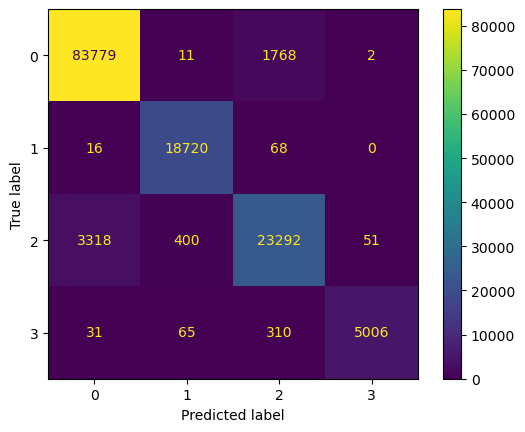

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = pipeline.classes_)
disp.plot()
plt.show()

### Evaluating the Effect of Balanced and Unbalanced Datasets

In [13]:
dataset['url_type'].value_counts()

url_type
0    428080
2    134094
1     95308
3     26700
Name: count, dtype: int64

In [14]:
# Upsampling

from sklearn.utils import resample

dataset_benign = dataset[(dataset['url_type'] == 0)]
dataset_defacement = dataset[(dataset['url_type'] == 1)]
dataset_phishing = dataset[(dataset['url_type'] == 2)]
dataset_malware = dataset[(dataset['url_type'] == 3)]

dataset_benign_upsampled = resample(dataset_benign,
                                        replace=True,
                                        n_samples = dataset_malware.shape[0],
                                        random_state = 15)

dataset_defacement_upsampled = resample(dataset_defacement,
                                        replace=True,
                                        n_samples = dataset_malware.shape[0],
                                        random_state = 15)

dataset_phishing_upsampled = resample(dataset_phishing,
                                        replace=True,
                                        n_samples = dataset_malware.shape[0],
                                        random_state = 15)

dataset_malware_upsampled = resample(dataset_malware,
                                        replace=True,
                                        n_samples = dataset_malware.shape[0],
                                        random_state = 15)


dataset_upsampled = pd.concat([dataset_benign_upsampled, dataset_defacement_upsampled, dataset_malware_upsampled, dataset_phishing_upsampled])

# dataset_upsampled.info(0)
dataset_upsampled['url_type'].value_counts()

url_type
0    26700
1    26700
3    26700
2    26700
Name: count, dtype: int64

In [15]:
x_up_train, x_up_test, y_up_train, y_up_test = train_test_split(dataset_upsampled.drop(columns=['url_type']), dataset_upsampled['url_type'], test_size = 0.2, random_state=42)

pipeline_up = Pipeline([
    ('classifier', RandomForestClassifier())
])

pipeline_up.fit(x_up_train, y_up_train)
y_up_pred = pipeline_up.predict(x_up_test)
print(classification_report(y_up_test, y_up_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5367
           1       0.97      1.00      0.98      5430
           2       0.92      0.89      0.90      5175
           3       0.99      0.97      0.97      5388

    accuracy                           0.95     21360
   macro avg       0.95      0.95      0.95     21360
weighted avg       0.95      0.95      0.95     21360



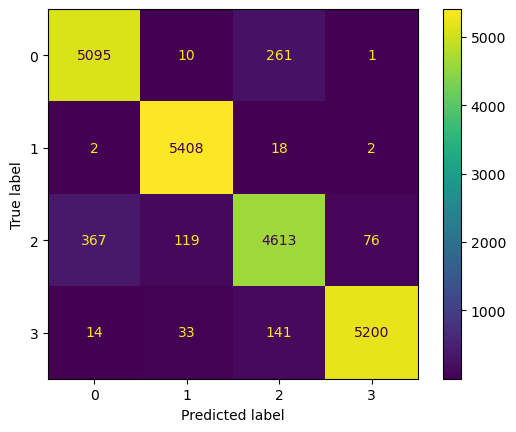

In [16]:
cm_up = confusion_matrix(y_up_test, y_up_pred, labels=pipeline_up.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_up, display_labels = pipeline_up.classes_)
disp.plot()
plt.show()

### Evaluating the Effect of Adding more Lexical Features

In [17]:
def get_numerical_values(url):
    url = url.replace('www.', '')
    
    return {
        'url_length': get_url_length(url),
        'letter_count': count_letters(url),
        'digits_count': count_digits(url),
        'special_chars_count': count_special_chars(url),
        '._count' : get_char_count(url,'.'),
        '-_count' : get_char_count(url,'-'),
        '__count' : get_char_count(url,'_'),
        '=_count' : get_char_count(url,'='),
        '/_count' : get_char_count(url,'/'),
        '?_count' : get_char_count(url,'?'),
        ';_count' : get_char_count(url,';'),
        '(_count' : get_char_count(url,'('),
        ')_count' : get_char_count(url,')'),
        '%_count' : get_char_count(url,'%'),
        '&_count' : get_char_count(url,'&'),
        '@_count' : get_char_count(url,'@')
    }

def get_url_length(url):
    return len(url)
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits
def count_special_chars(url):
    special_chars = "!@#$%^&*()_+-=[]{};:,.<>/?`~|"
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars
def get_char_count(url, char):
    """
    Takes an input string url and string char and returns the number of times (in int) the input char is seen in the url.
    """
    count = 0
    for i in url:
        if i == char:
            count += 1
    return(count)

In [18]:
import feature_generation_lexical_function

def generator(url):

    temp = [[url]]
    url_test = pd.DataFrame(temp, columns=['url'])

    print("First 10 Features")
    print("------------------")
    url_test['url_length'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_length(x))
    print("Feature 1 Done...")

    url_test['url_ip_in_domain'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_ip_in_domain(x))
    print("Feature 2 Done...")

    url_test['url_domain_entropy'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_domain_entropy(x))
    print("Feature 3 Done...")

    url_test['url_is_digits_in_domain'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_is_digits_in_domain(x))
    print("Feature 4 Done...")

    url_test['url_query_length'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_query_length(x))
    print("Feature 5 Done...")

    url_test['url_number_of_parameters'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_number_of_parameters(x))
    print("Feature 6 Done...")

    url_test['url_number_of_digits'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_number_of_digits(x))
    print("Feature 7 Done...")

    url_test['url_string_entropy'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_string_entropy(x))
    print("Feature 8 Done...")

    url_test['url_is_https'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_is_https(x))
    print("Feature 9 Done...")

    url_test['url_path_length'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_path_length(x))
    print("Feature 10 Done...")

    print("Features 11-20")
    print("------------------")
    url_test['url_host_length'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_host_length(x))
    print("Feature 11 Done...")

    url_test['url_number_of_subdirectories'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_number_of_subdirectories(x))
    print("Feature 12 Done...")

    url_test['get_tld'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.get_tld(x))
    print("Feature 13 Done...")

    url_test['url_domain_len'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_domain_len(x))
    print("Feature 14 Done...")

    url_test['url_num_subdomain'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_num_subdomain(x))
    print("Feature 15 Done...")

    url_test['url_has_port'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_has_port(x))
    print("Feature 16 Done...")

    url_test['url_number_of_fragments'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_number_of_fragments(x))
    print("Feature 17 Done...")

    url_test['url_is_encoded'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_is_encoded(x))
    print("Feature 18 Done...")

    url_test['url_number_of_letters'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_number_of_letters(x))
    print("Feature 19 Done...")

    url_test['url_num_periods'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_num_periods(x))
    print("Feature 20 Done...")

    print("Features 21-30")
    print("------------------")
    url_test['url_num_of_hyphens'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_num_of_hyphens(x))
    print("Feature 21 Done...")

    url_test['url_num_underscore'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_num_underscore(x))
    print("Feature 22 Done...")

    url_test['url_num_equal'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_num_equal(x))
    print("Feature 23 Done...")

    url_test['url_num_forward_slash'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_num_forward_slash(x))
    print("Feature 24 Done...")

    url_test['url_num_question_mark'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_num_question_mark(x))
    print("Feature 25 Done...")

    url_test['url_num_semicolon'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_num_semicolon(x))
    print("Feature 26 Done...")

    url_test['url_num_open_parenthesis'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_num_open_parenthesis(x))
    print("Feature 27 Done...")

    url_test['url_num_close_parenthesis'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_num_close_parenthesis(x))
    print("Feature 28 Done...")

    url_test['url_num_mod_sign'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_num_mod_sign(x))
    print("Feature 29 Done...")

    url_test['url_num_ampersand'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_num_ampersand(x))
    print("Feature 30 Done...")

    print("Features 31-40")
    print("------------------")
    url_test['url_num_at'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.url_num_at(x))
    print("Feature 31 Done...")

    url_test['has_secure_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_secure_in_string(x))
    print("Feature 32 Done...")

    url_test['has_account_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_account_in_string(x))
    print("Feature 33 Done...")

    url_test['has_webscr_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_webscr_in_string(x))
    print("Feature 34 Done...")

    url_test['has_login_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_login_in_string(x))
    print("Feature 35 Done...")

    url_test['has_ebayisapi_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_ebayisapi_in_string(x))
    print("Feature 36 Done...")

    url_test['has_signin_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_signin_in_string(x))
    print("Feature 37 Done...")

    url_test['has_banking_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_banking_in_string(x))
    print("Feature 38 Done...")

    url_test['has_confirm_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_confirm_in_string(x))
    print("Feature 39 Done...")

    url_test['has_blog_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_blog_in_string(x))
    print("Feature 40 Done...")

    print("Features 41-50")
    print("------------------")
    url_test['has_logon_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_logon_in_string(x))
    print("Feature 41 Done...")

    url_test['has_signon_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_signon_in_string(x))
    print("Feature 42 Done...")

    url_test['has_loginasp_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_loginasp_in_string(x))
    print("Feature 43 Done...")

    url_test['has_loginphp_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_loginphp_in_string(x))
    print("Feature 44 Done...")

    url_test['has_loginhtm_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_loginhtm_in_string(x))
    print("Feature 45 Done...")

    url_test['has_exe_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_exe_in_string(x))
    print("Feature 46 Done...")

    url_test['has_zip_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_zip_in_string(x))
    print("Feature 47 Done...")

    url_test['has_rar_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_rar_in_string(x))
    print("Feature 48 Done...")

    url_test['has_jpg_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_jpg_in_string(x))
    print("Feature 49 Done...")

    url_test['has_gif_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_gif_in_string(x))
    print("Feature 50 Done...")

    print("Features 51-60")
    print("------------------")
    url_test['has_viewerphp_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_viewerphp_in_string(x))
    print("Feature 51 Done...")

    url_test['has_linkeq_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_linkeq_in_string(x))
    print("Feature 52 Done...")

    url_test['has_getImageasp_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_getImageasp_in_string(x))
    print("Feature 53 Done...")

    url_test['has_plugins_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_plugins_in_string(x))
    print("Feature 54 Done...")

    url_test['has_paypal_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_paypal_in_string(x))
    print("Feature 55 Done...")

    url_test['has_order_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_order_in_string(x))
    print("Feature 56 Done...")

    url_test['has_dbsysphp_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_dbsysphp_in_string(x))
    print("Feature 57 Done...")

    url_test['has_configbin_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_configbin_in_string(x))
    print("Feature 58 Done...")

    url_test['has_downloadphp_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_downloadphp_in_string(x))
    print("Feature 59 Done...")

    url_test['has_js_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_js_in_string(x))
    print("Feature 60 Done...")

    print("Features 61-70")
    print("------------------")
    url_test['has_payment_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_payment_in_string(x))
    print("Feature 61 Done...")

    url_test['has_files_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_files_in_string(x))
    print("Feature 62 Done...")

    url_test['has_css_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_css_in_string(x))
    print("Feature 63 Done...")

    url_test['has_shopping_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_shopping_in_string(x))
    print("Feature 64 Done...")

    url_test['has_mailphp_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_mailphp_in_string(x))
    print("Feature 65 Done...")

    url_test['has_jar_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_jar_in_string(x))
    print("Feature 66 Done...")

    url_test['has_swf_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_swf_in_string(x))
    print("Feature 67 Done...")

    url_test['has_cgi_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_cgi_in_string(x))
    print("Feature 68 Done...")

    url_test['has_php_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_php_in_string(x))
    print("Feature 69 Done...")

    url_test['has_abuse_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_abuse_in_string(x))
    print("Feature 70 Done...")

    print("Features 71-75")
    print("------------------")
    url_test['has_admin_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_admin_in_string(x))
    print("Feature 71 Done...")

    url_test['has_bin_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_bin_in_string(x))
    print("Feature 72 Done...")

    url_test['has_personal_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_personal_in_string(x))
    print("Feature 73 Done...")

    url_test['has_update_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_update_in_string(x))
    print("Feature 74 Done...")

    url_test['has_verification_in_string'] = url_test['url'].apply(lambda x: feature_generation_lexical_function.has_verification_in_string(x))
    print("Feature 75 Done...")

    url_test = url_test.drop(columns=['url'])

    return url_test

start = time.perf_counter()
numerical_values = generator('https://www.overleaf.com/project/657c1e9aa65bd48f6d65f413')
end = time.perf_counter()

print(end-start)


First 10 Features
------------------
Feature 1 Done...
Feature 2 Done...
Feature 3 Done...
Feature 4 Done...
Feature 5 Done...
Feature 6 Done...
Feature 7 Done...
Feature 8 Done...
Feature 9 Done...
Feature 10 Done...
Features 11-20
------------------
Feature 11 Done...
Feature 12 Done...
Feature 13 Done...
Feature 14 Done...
Feature 15 Done...
Feature 16 Done...
Feature 17 Done...
Feature 18 Done...
Feature 19 Done...
Feature 20 Done...
Features 21-30
------------------
Feature 21 Done...
Feature 22 Done...
Feature 23 Done...
Feature 24 Done...
Feature 25 Done...
Feature 26 Done...
Feature 27 Done...
Feature 28 Done...
Feature 29 Done...
Feature 30 Done...
Features 31-40
------------------
Feature 31 Done...
Feature 32 Done...
Feature 33 Done...
Feature 34 Done...
Feature 35 Done...
Feature 36 Done...
Feature 37 Done...
Feature 38 Done...
Feature 39 Done...
Feature 40 Done...
Features 41-50
------------------
Feature 41 Done...
Feature 42 Done...
Feature 43 Done...
Feature 44 Done...


In [19]:
results = []

for i in range(3):
    pipeline = Pipeline([('classifier', RandomForestClassifier())])

    temp_url_features = x_train.iloc[:, 0:25*(i+1)]
    
    pipeline.fit(temp_url_features, y_train)
    
    url_type_predict = pipeline.predict(x_test.iloc[:, 0:25*(i+1)])

    start = time.perf_counter()
    numerical_values = generator('https://www.overleaf.com/project/657c1e9aa65bd48f6d65f413')
    pipeline.predict(numerical_values)

    end = time.perf_counter()

    prediction_time = end-start

    accuracy = accuracy_score(y_test, url_type_predict)
    recall = recall_score(y_test, url_type_predict, average = 'weighted')
    precision = precision_score(y_test, url_type_predict, average = 'weighted', zero_division=1)
    f1 = f1_score(y_test, url_type_predict, average = 'weighted')
    results.append(((4*(i+1)), accuracy, recall, precision, f1, prediction_time))

First 10 Features
------------------
Feature 1 Done...
Feature 2 Done...
Feature 3 Done...
Feature 4 Done...
Feature 5 Done...
Feature 6 Done...
Feature 7 Done...
Feature 8 Done...
Feature 9 Done...
Feature 10 Done...
Features 11-20
------------------
Feature 11 Done...
Feature 12 Done...
Feature 13 Done...
Feature 14 Done...
Feature 15 Done...
Feature 16 Done...
Feature 17 Done...
Feature 18 Done...
Feature 19 Done...
Feature 20 Done...
Features 21-30
------------------
Feature 21 Done...
Feature 22 Done...
Feature 23 Done...
Feature 24 Done...
Feature 25 Done...
Feature 26 Done...
Feature 27 Done...
Feature 28 Done...
Feature 29 Done...
Feature 30 Done...
Features 31-40
------------------
Feature 31 Done...
Feature 32 Done...
Feature 33 Done...
Feature 34 Done...
Feature 35 Done...
Feature 36 Done...
Feature 37 Done...
Feature 38 Done...
Feature 39 Done...
Feature 40 Done...
Features 41-50
------------------
Feature 41 Done...
Feature 42 Done...
Feature 43 Done...
Feature 44 Done...


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- has_abuse_in_string
- has_account_in_string
- has_admin_in_string
- has_banking_in_string
- has_bin_in_string
- ...


In [ ]:
results = pd.DataFrame(results, columns=['Number of Features', 'Accuracy', 'Recall', 'Precision', 'F1-Score', 'Score Time'])
results = results.sort_values(by='Number of Features', ascending=True)
print(results)

   Number of Features  Accuracy    Recall  Precision  F1-Score  Score Time
0                   4  0.955363  0.955363   0.954844  0.954819    0.028109


Observations:
- Increasing the number of features improves all the class weighted metrics of the model at the cost of a higher training time.